In [ ]:
##### Fig. 5 - Acoustic and categorical representations for phonemes and prosody in ventral and dorsal stream regions
#
# written by S-C. Baek
# updated date: 15.12.2024
#

In [1]:
# import packages
import os
import sys
import pickle

import numpy as np

from mne.stats.multi_comp import fdr_correction

import matplotlib
import matplotlib.pyplot as plt

In [2]:
# path settings
FIGDIR  = os.getcwd()
MAINDIR = os.path.abspath('..')
DATADIR = MAINDIR + os.sep + 'data/'
PYDIR   = MAINDIR + os.sep + 'code' + os.sep + 'python/'

In [3]:
# add path to PYDIR to import functions
if PYDIR not in sys.path:
    sys.path.insert(1, PYDIR)
from utils import fisher_z_transform

In [4]:
# subjects
s = os.listdir(DATADIR)
subjects = [i for i in s if 'sub-' in i]
subjects.sort()
n_subjects = len(subjects)

In [5]:
# linguistic elements
elements = ['phoneme', 'prosody']
n_elements = len(elements)

In [6]:
 # colors
cmap = matplotlib.colormaps['tab10']
colors = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]
color_indices = np.array([9, 6, 2, 1, 4])
colors = np.array(colors)[color_indices]

In [ ]:
# Fig. 5a,b/c,d - acoustic and categorical representations for phonemes or prosody in 10 ROIs

In [7]:
# element to plot
ei = 0 # 0: phonemes, 1: prosody
element = elements[ei]

# onset of relevant acoustic landmarks and stimulus offset
tonoff = np.zeros( (2,2) )
if element == 'phoneme':
    tonoff[0,:] = np.array([0.026, 0.062]) # voicing, in s
else:
    tonoff[0,:] = np.array([0.184, 0.250]) # pitch divergence, in s
tonoff[1,:] = np.array([0.464, 0.550]) # offset, in s

In [8]:
# get data configuration
fname = DATADIR + subjects[0] + os.sep + 'meg' + os.sep +\
        'rsa_rois_' + element + '_uni.pickle'
with open(fname, 'rb') as f:
    tmp = pickle.load(f)
n_rois, n_times, n_models = tmp['rsa_vals'].shape
    
# reconstrunct time info.
tmin  = tmp['tmin']
tstep = tmp['tstep']
tmax  = tmin + tstep*(n_times-1)
times = np.linspace(tmin, tmax, n_times)

# ROI labels for plotting
rois = np.array(tmp['labels'])
del fname, tmp

In [9]:
# import data
X = np.zeros( (n_rois, n_times, n_models, n_subjects) ) # init a matrix

# loop over subjects
for subi, subject in enumerate(subjects):
    
    # import individual data
    fname = DATADIR + subject + os.sep + 'meg' + os.sep + 'rsa_rois_' + element + '_uni.pickle' # general represent.
    with open(fname, 'rb') as f:
        rsa_rois = pickle.load(f)
    X[:,:,:,subi] = rsa_rois['rsa_vals']
    del fname, rsa_rois
    
# apply Fisher Z transformation to R^2 after taking sqrt of it
X = fisher_z_transform(X, sqrt=True)

# apply baseline correction to the data
t0Idx = np.argmin(np.abs(times)) # onset index
Z = X - np.mean(X[:, :t0Idx, :, :], axis=1)[:, np.newaxis, :] # baseline correction

In [10]:
 # import ROI-wise cluster statistics
fname = DATADIR + 'group' + os.sep + 'meg' + os.sep + 'rsa_rois_' + element + '_uni_vs_baseline_p05.pickle'
with open(fname, 'rb') as f:
    cluster_stats_models = pickle.load(f)

In [11]:
# FDR correction based on the minimum p-value of each ROI

# list to store significant clusters for each model
sig_clusters_models = list()

# loop over models
for cluster_stats_rois in cluster_stats_models: # acoustic and then categorical representations
    
    # FDR correction
    pvals = list()
    for roii in range(n_rois): # loop over rois
        if len(cluster_stats_rois[roii][1]) > 0:
            pvals.append(np.min(cluster_stats_rois[roii][1]))
        else:
            pvals.append(0.99)
    reject, pvals_correct = fdr_correction(pvals) # apply FDR correction
    factor = pvals_correct / pvals
    
    # getting sigificant clusters after the correction
    sig_clusters = list()
    sig_clusters_pval = list()
    for roii in range(n_rois):
        if reject[roii]:
            # points consisting of a cluster
            sig_ids = np.where(cluster_stats_rois[roii][1] * factor[roii] < 0.05)[0]
            sig_pnts = [cluster_stats_rois[roii][0][idx] for idx in sig_ids] 
            sig_clusters.append(sig_pnts)
        
            # cluster-wise p-valse 
            sig_pvals = [cluster_stats_rois[roii][1][idx] for idx in sig_ids]
            sig_clusters_pval.append(sig_pvals)
        else:
            sig_clusters.append([])
            sig_clusters_pval.append([])
            
    # put model-wise results into a bigger list
    sig_clusters_rois = (sig_clusters, sig_clusters_pval)
    sig_clusters_models.append(sig_clusters_rois) 

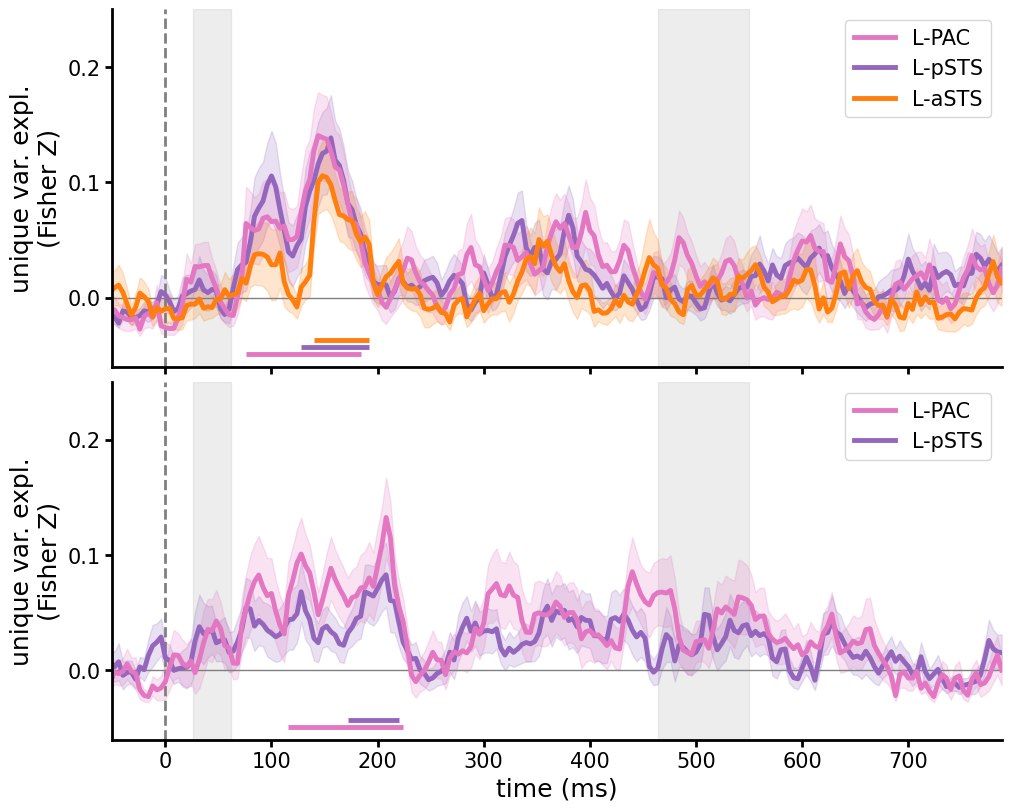

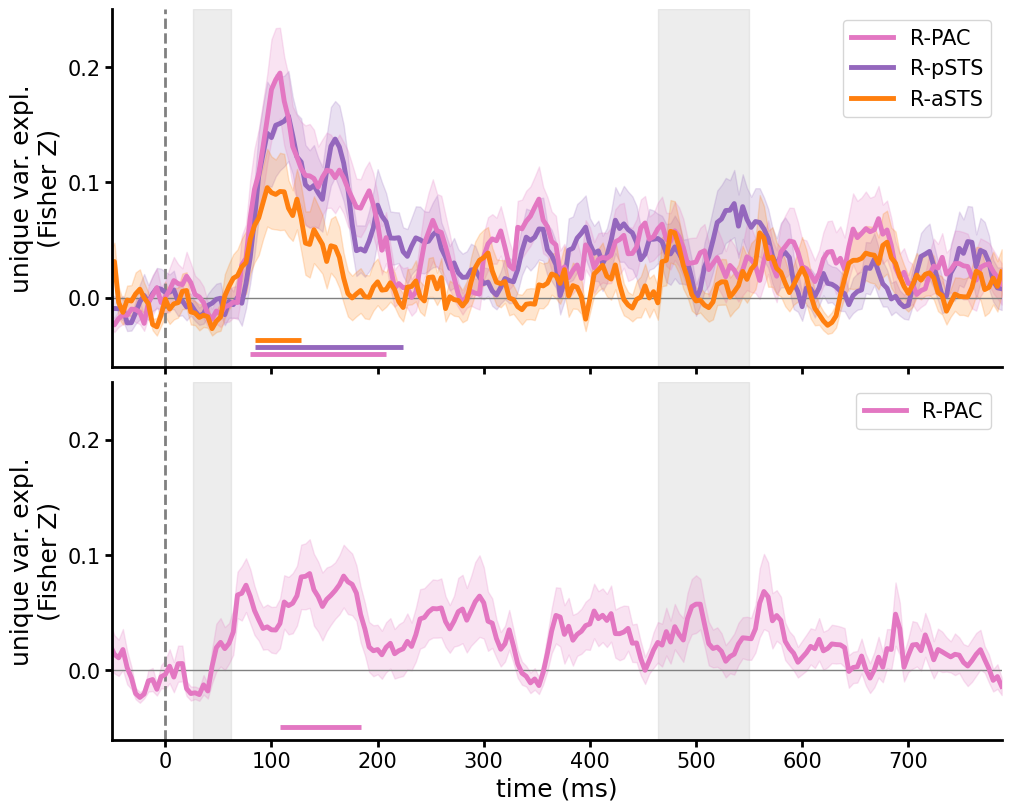

In [12]:
# group-level data for plotting
m     = np.mean(Z, axis=-1) # mean
sem   = np.std(Z, axis=-1) / np.sqrt(n_subjects) # sem
upper = m + sem
lower = m - sem

# range of x- & y-axis
xlim  = (-50, times[-1]*1e3)
x0Idx = np.argmin(np.abs(times - xlim[0]*1e-3))
ylim  = (-0.06, 0.25)
    
# loop over hemispheres
for hemi in ['L', 'R']:

    # rois in each hemisphere
    roi_inds = [ri for ri, roi in enumerate(rois) if hemi in roi]
    roi_inds = np.array(roi_inds)
    
    # figure
    fig, ax = plt.subplots(2,1, figsize=(10,8), constrained_layout=True)
    
    # loop over n_models
    for i in range(n_models):
        
        # accessories first
        ax[i].vlines(0, ylim[0], ylim[1], linewidth=2.0, linestyle='--', color=np.ones(3)*0.5) # stimulus onset
        ax[i].hlines(0, xlim[0], xlim[1], linewidth=1.0, color=np.ones(3)*0.5)
        ax[i].fill_between(tonoff[0,:]*1e3, np.ones(2)*ylim[0], np.ones(2)*ylim[1], 
                    color='#A9A9A9', alpha=0.2) # acoustic landmark
        ax[i].fill_between(tonoff[1,:]*1e3, np.ones(2)*ylim[0], np.ones(2)*ylim[1], 
                        color='#A9A9A9', alpha=0.2) # stimulus offset
        
        # plot RSA results
        porder = np.array([4,1,3,0,2]) # plotting order of regions
        mask  = np.zeros(len(roi_inds), dtype=bool)
        for roii in roi_inds[porder]:
            if sig_clusters_models[i][1][roii]: # plotting only significant ROIs
                mask[roii%5]=True # to record significant ROIs for legend
                # line plot for mean & s.e.m
                ax[i].plot(1e3*times[x0Idx:], m[roii,x0Idx:,i], color=colors[roii%5], 
                           linewidth=3.5, label=rois[roii])
                ax[i].fill_between(1e3*times[x0Idx:], upper[roii,x0Idx:,i], lower[roii,x0Idx:,i], 
                                   color=colors[roii%5], alpha=0.2)
            
        # mark significant interval 
        x_pos = -0.025
        iorder = np.array([0,2,3,4,1])
        for roii in roi_inds[iorder]:
            sig_points = sig_clusters_models[i][0][roii] # first index for a model & second for pnts | pvals
            for pnt in sig_points:
                ax[i].hlines(x_pos, times[t0Idx+pnt[0][0]]*1e3, times[t0Idx+pnt[0][-1]]*1e3,
                             color=colors[roii % 5], linewidth=3.5)
            x_pos -= 0.006
        
        # for reordering legend
        lorder = np.array([0, 2, 1, 4, 3])
        orig_order = np.argsort(roi_inds[porder][mask[porder]])
        new_order = np.argsort(roi_inds[lorder][mask[lorder]])
        
        # accessories
        ax[i].legend()
        handles, labels = ax[i].get_legend_handles_labels()
        order = np.argsort(labels)
        ax[i].legend(np.array(handles)[orig_order][new_order], np.array(labels)[orig_order][new_order], 
                     loc='upper right', fontsize=15)
        ax[i].set_xlim(xlim[0], xlim[-1])
        ax[i].set_xticklabels([]) if i == 0 else ax[i].tick_params(axis='x', labelsize=15)
        ax[i].set_xlabel('time (ms)', fontsize=18) if i == 1 else ax[i].set_xlabel('')
        ax[i].set_ylim(ylim[0], ylim[1]) # fixed range
        ax[i].set_yticks([0, 0.1, 0.2])
        ax[i].tick_params(axis='y', labelsize=15)
        ax[i].set_ylabel('unique var. expl.\n(Fisher Z)', fontsize=18)
        ax[i].spines['right'].set_visible(False)
        ax[i].spines['top'].set_visible(False)
        for axis in ['top','bottom','left','right']:
            ax[i].spines[axis].set_linewidth(2)
        ax[i].xaxis.set_tick_params(length=5, width=2)
        ax[i].yaxis.set_tick_params(length=5, width=2)